# T3 - Running scenarios

While running individual sims can be interesting for simple explorations, at some point it will almost always be necessary to run a large number of simulations simultaneously -- to explore different scenarios, to perform calibration, or simply to get uncertainty bounds on a single projection. This tutorial explains how to do that.

<div class="alert alert-info">
    
Click [here](https://mybinder.org/v2/gh/institutefordiseasemodeling/covasim/HEAD?urlpath=lab%2Ftree%2Fdocs%2Ftutorials%2Ftut_running.ipynb) to open an interactive version of this notebook.
    
</div>

## Running with MultiSims

The most common way to run multiple simulations is with the *MultiSim* object. As the name suggests, this is a relatively simple container for a number of sims. However, it contains powerful methods for plotting, statistics, and running all the sims in parallel.

### Running one sim with uncertainty

Making and running a multisim based on a single sim is pretty easy:

Covasim 3.1.4 (2022-10-22) — © 2020-2022 by IDM


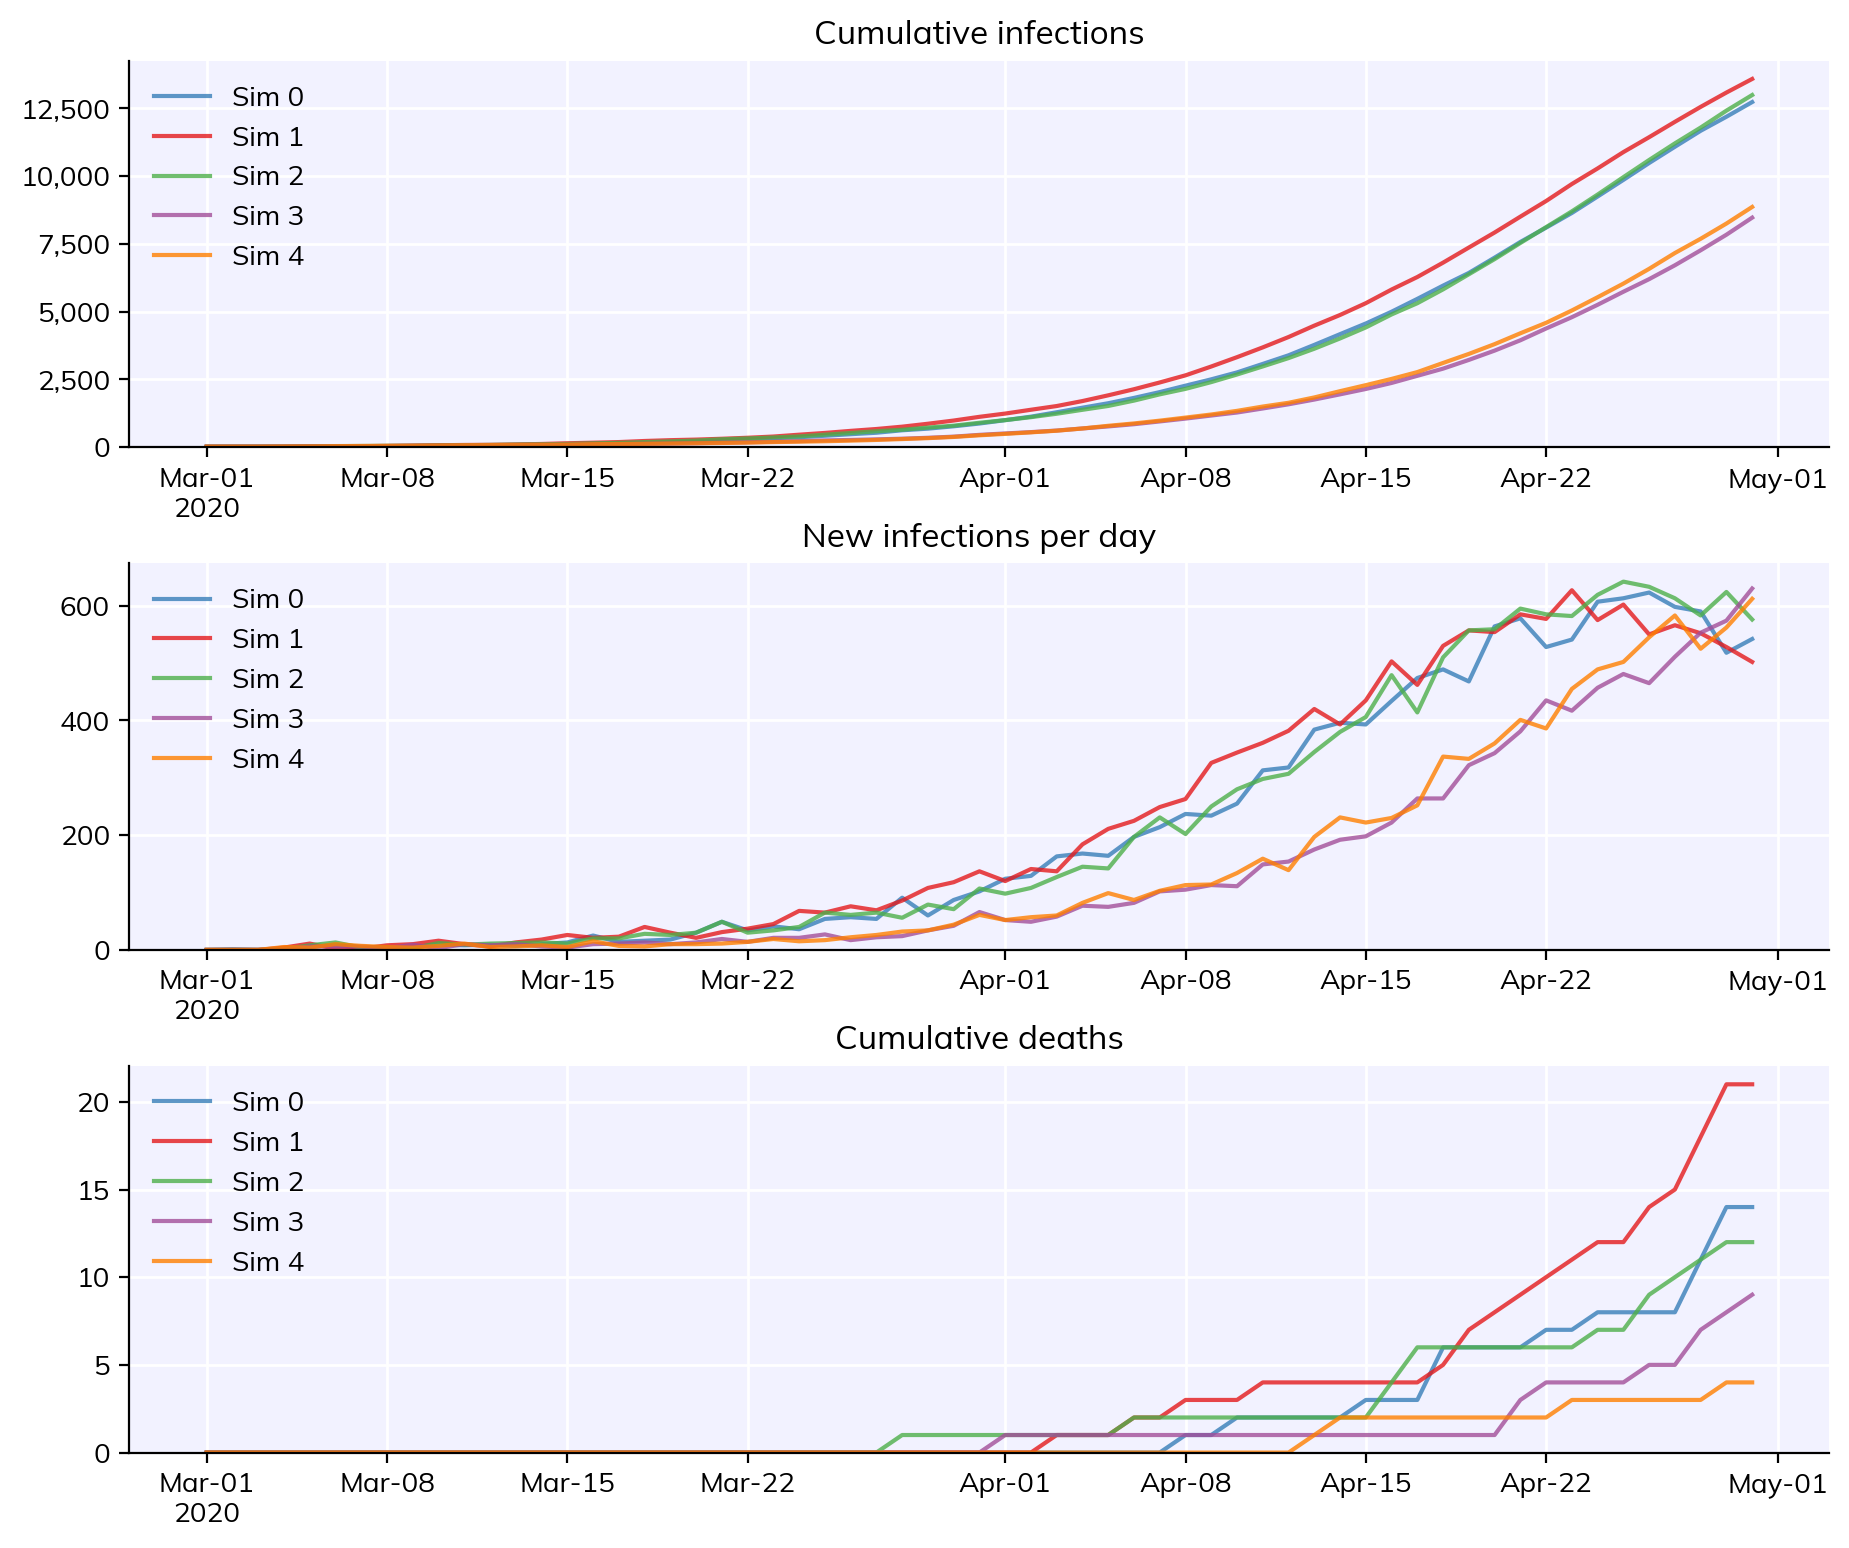

In [1]:
import covasim as cv
cv.options(jupyter=True, verbose=0)

sim = cv.Sim()
msim = cv.MultiSim(sim)
msim.run(n_runs=5)
msim.plot()

If you run a multisim with a single sim input as above, it will change the random seed for each sim, which is what leads to the variability you see.

By default, the multisim simply plots each simulation. These simulations are stored in the `sims` attribute, which is just a simple list of sims:

In [2]:
for sim in msim.sims:
    sim.brief()

Sim("Sim 0"; 2020-03-01 to 2020-04-30; pop: 20000 random; epi: 12730⚙, 14☠)
Sim("Sim 1"; 2020-03-01 to 2020-04-30; pop: 20000 random; epi: 13582⚙, 21☠)
Sim("Sim 2"; 2020-03-01 to 2020-04-30; pop: 20000 random; epi: 12989⚙, 12☠)
Sim("Sim 3"; 2020-03-01 to 2020-04-30; pop: 20000 random; epi: 8467⚙, 9☠)
Sim("Sim 4"; 2020-03-01 to 2020-04-30; pop: 20000 random; epi: 8861⚙, 4☠)


However, often (especially when you run the same parameters with different random seeds), you don't care about the individual sims, you want to see the *statistics* for the sims. You can calculate either the mean or the median of the results across all the sims as follows:

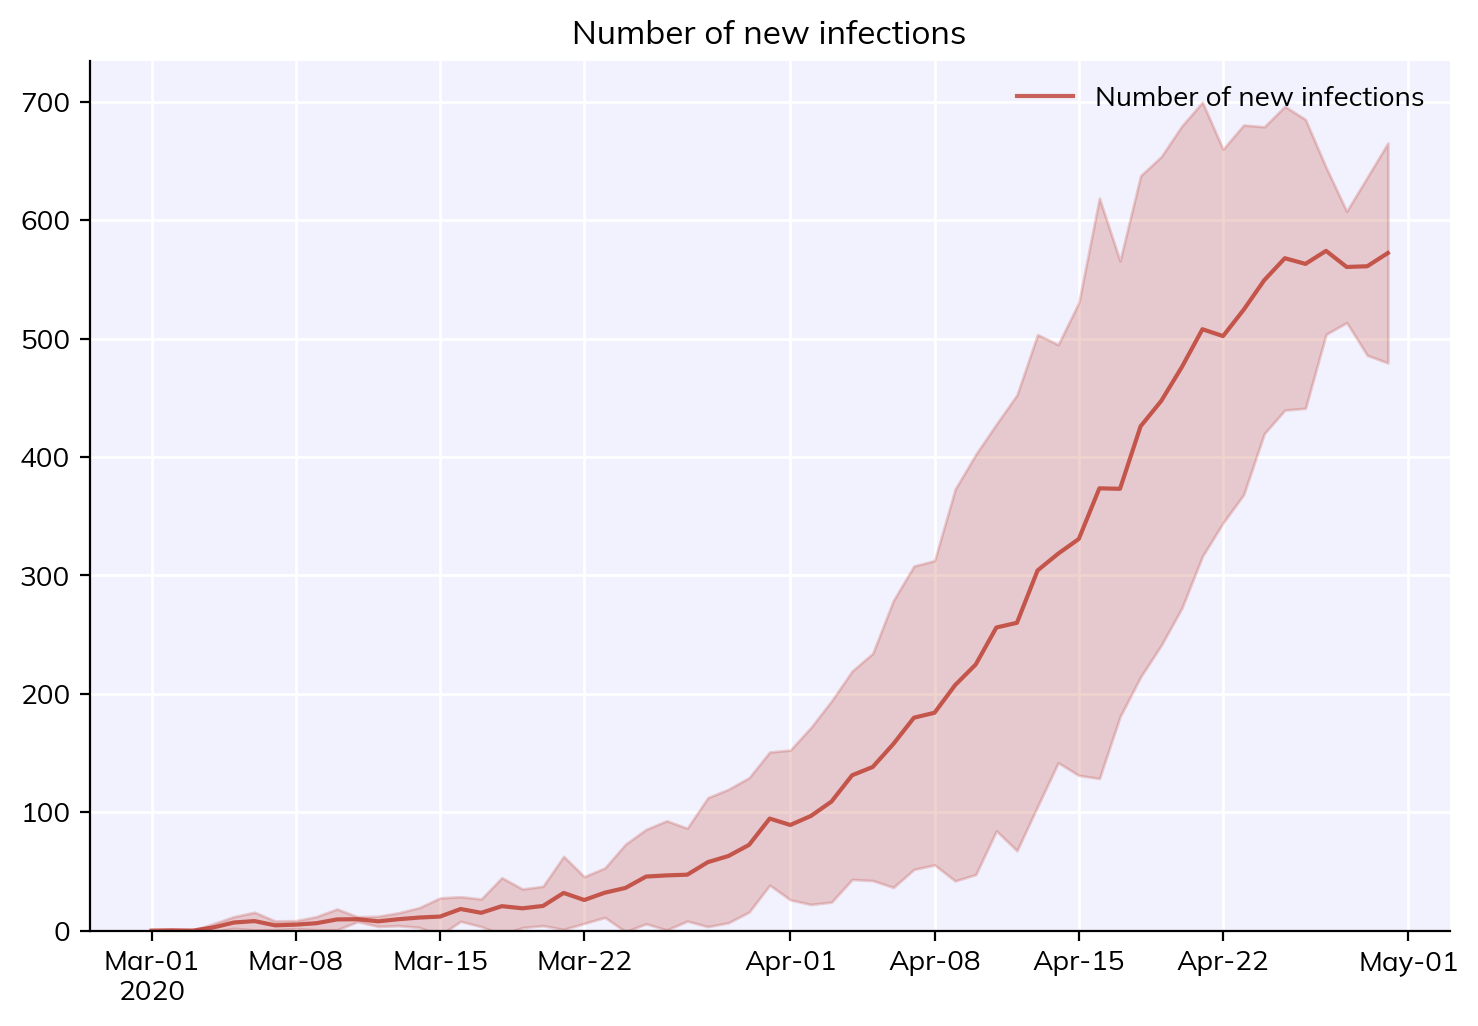

In [3]:
msim.mean()
msim.plot_result('new_infections')

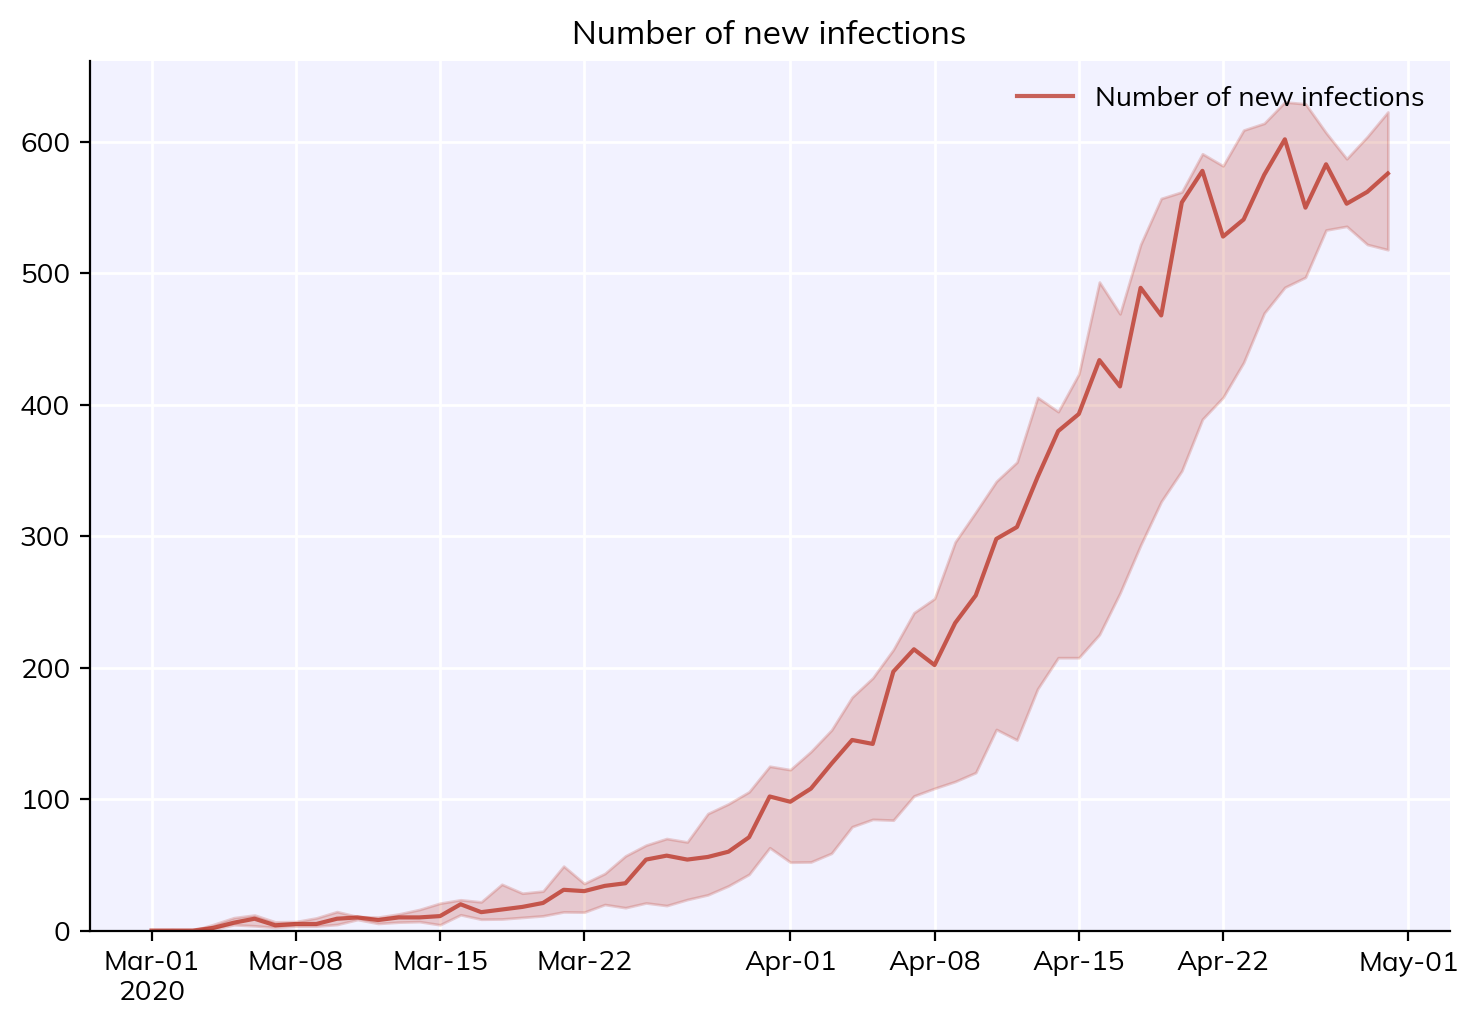

In [4]:
msim.median()
msim.plot_result('new_infections')

You can see these are similar, but slightly different. You can also treat each of the individual sims as part of a larger single sim, and "combine" the results into one sim:

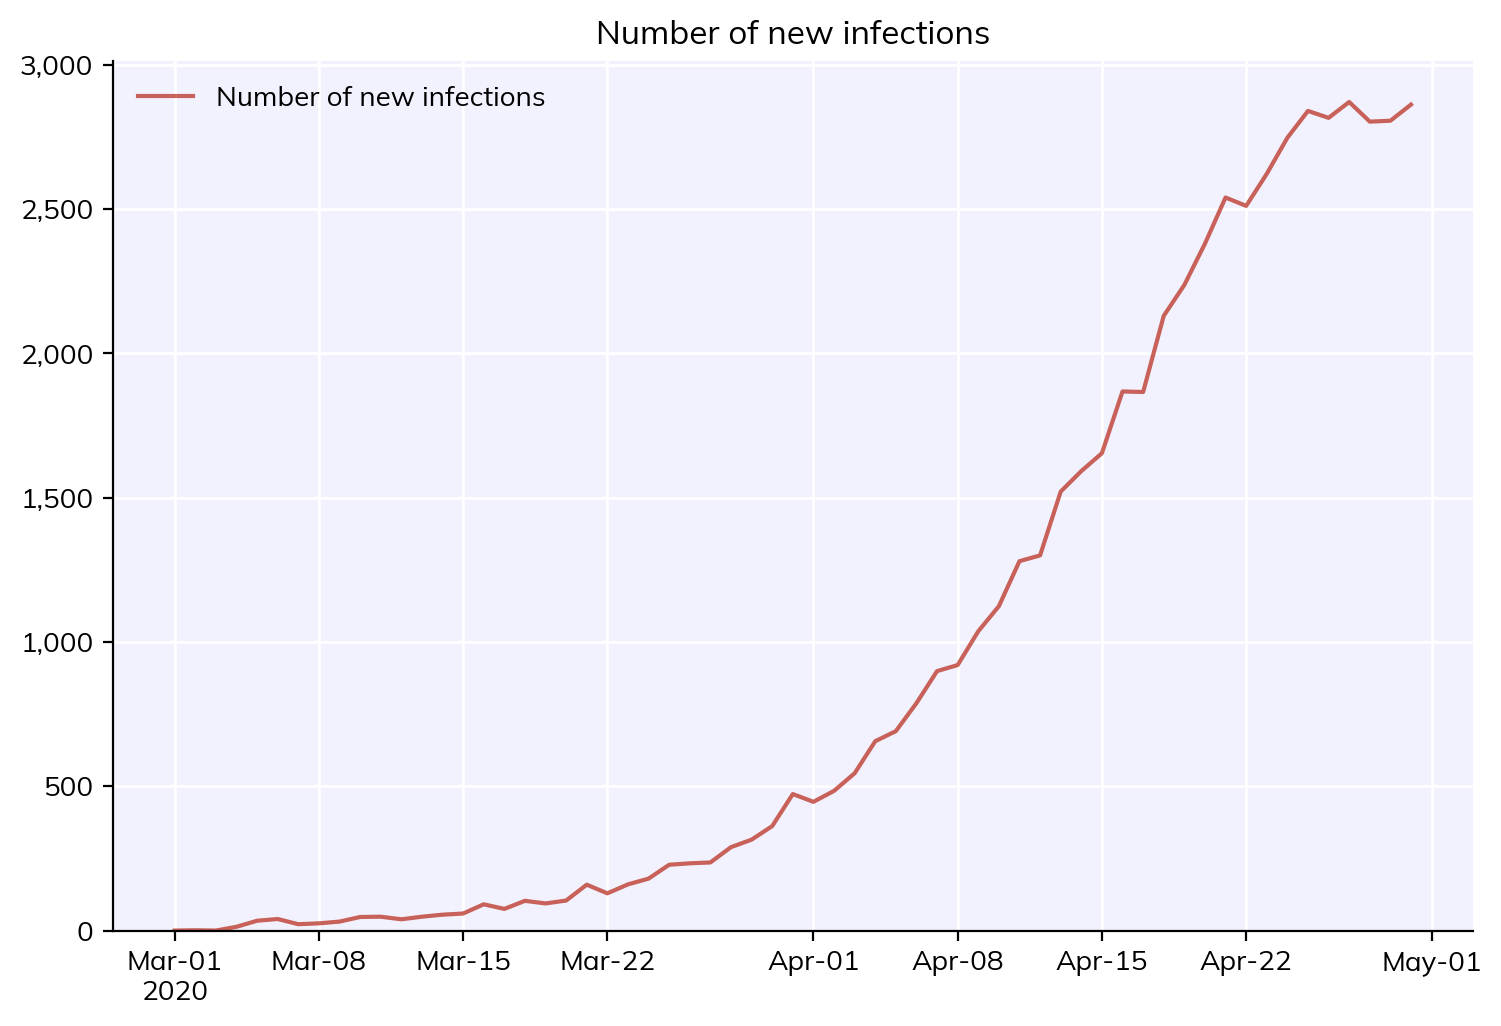

In [5]:
msim.combine()
msim.plot_result('new_infections')

Note how now there is no uncertainty and the total number of infections is 5x higher than in the previous plots, since we just added 5 different sims together.

Each of these operations modifies the `msim.base_sim` object, and does not affect the actual list of stored sims, which is why you can go back and forth between them.

### Running different sims

Often you don't want to run the same sim with different seeds, but instead want to run a set of different sims. That's also very easy -- for example, here's how you would do a sweep across beta values:

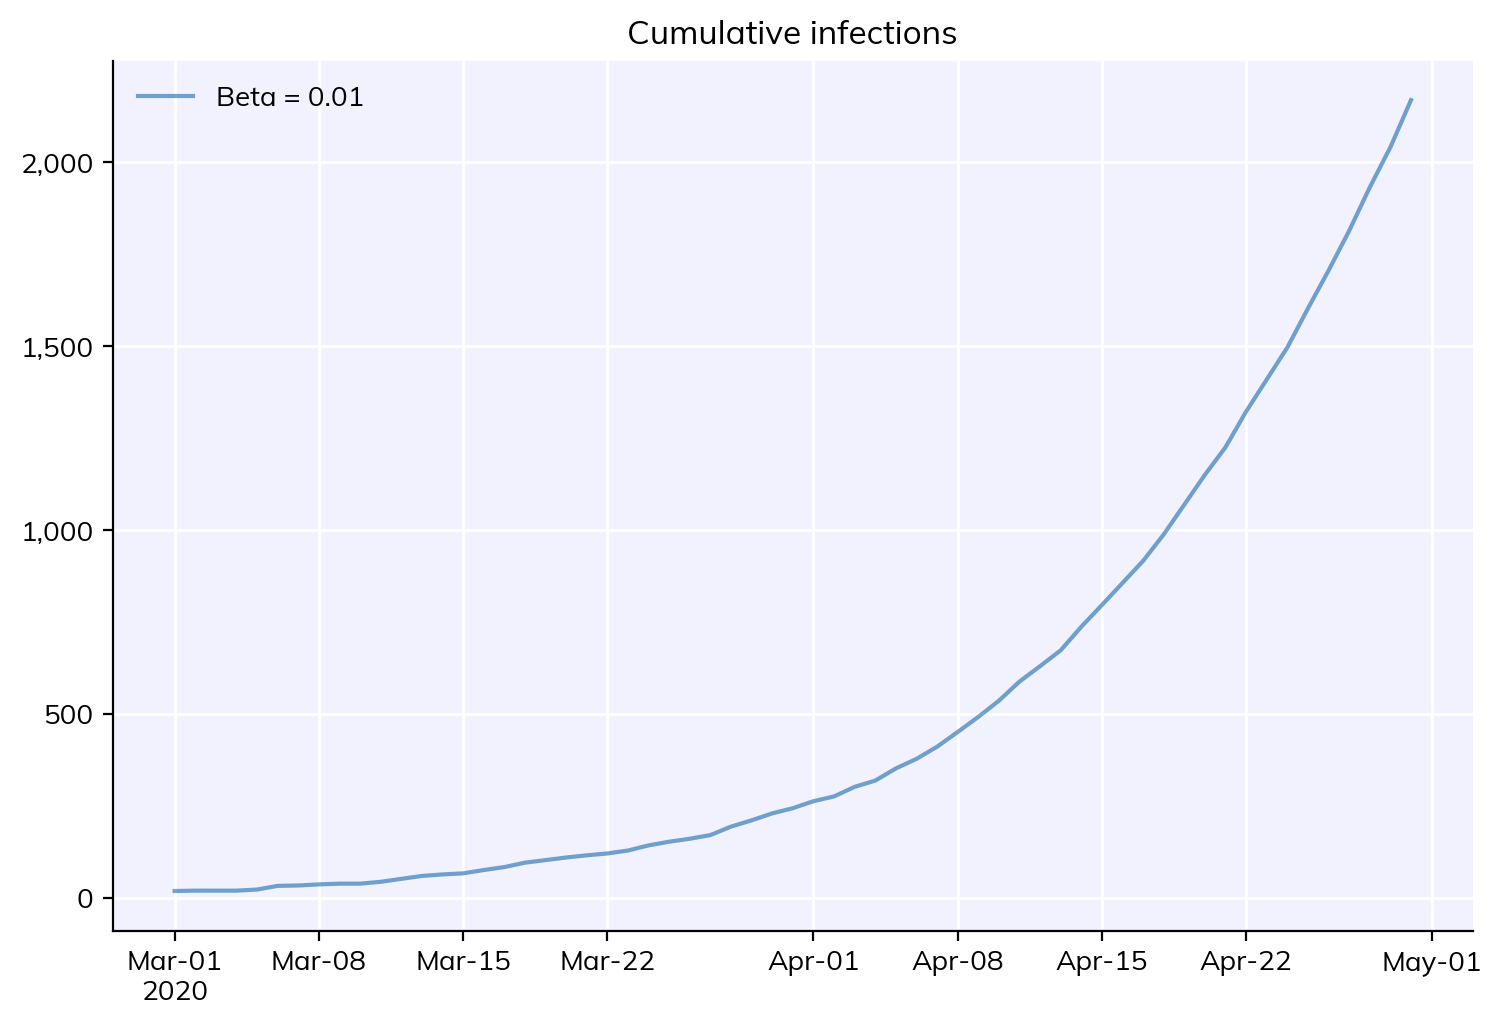

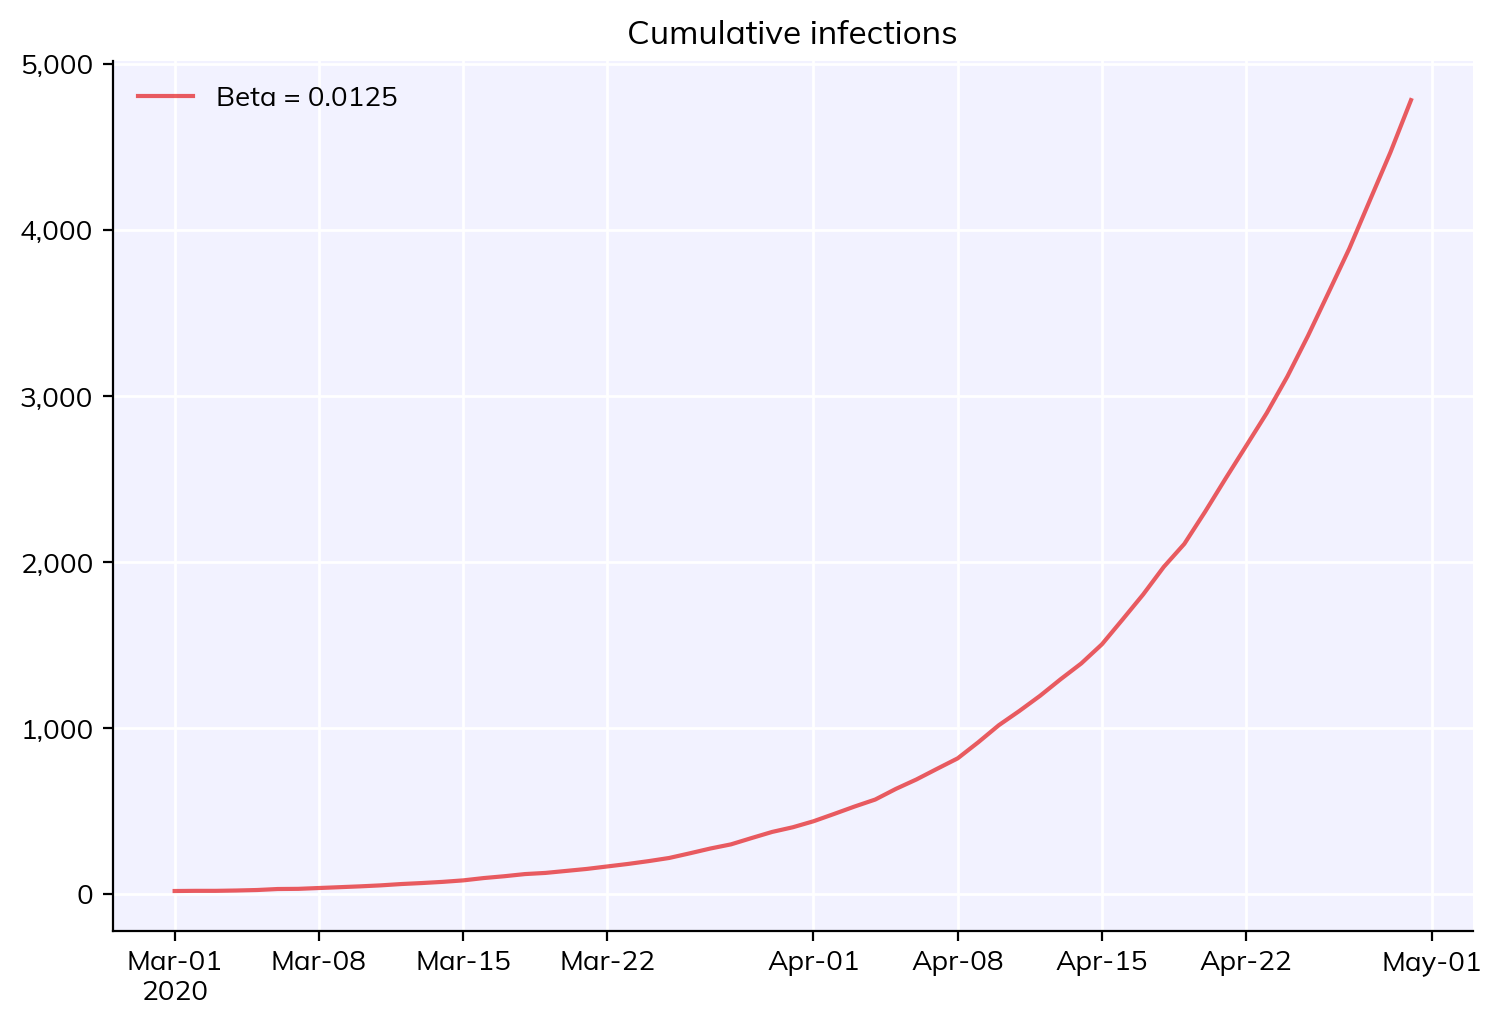

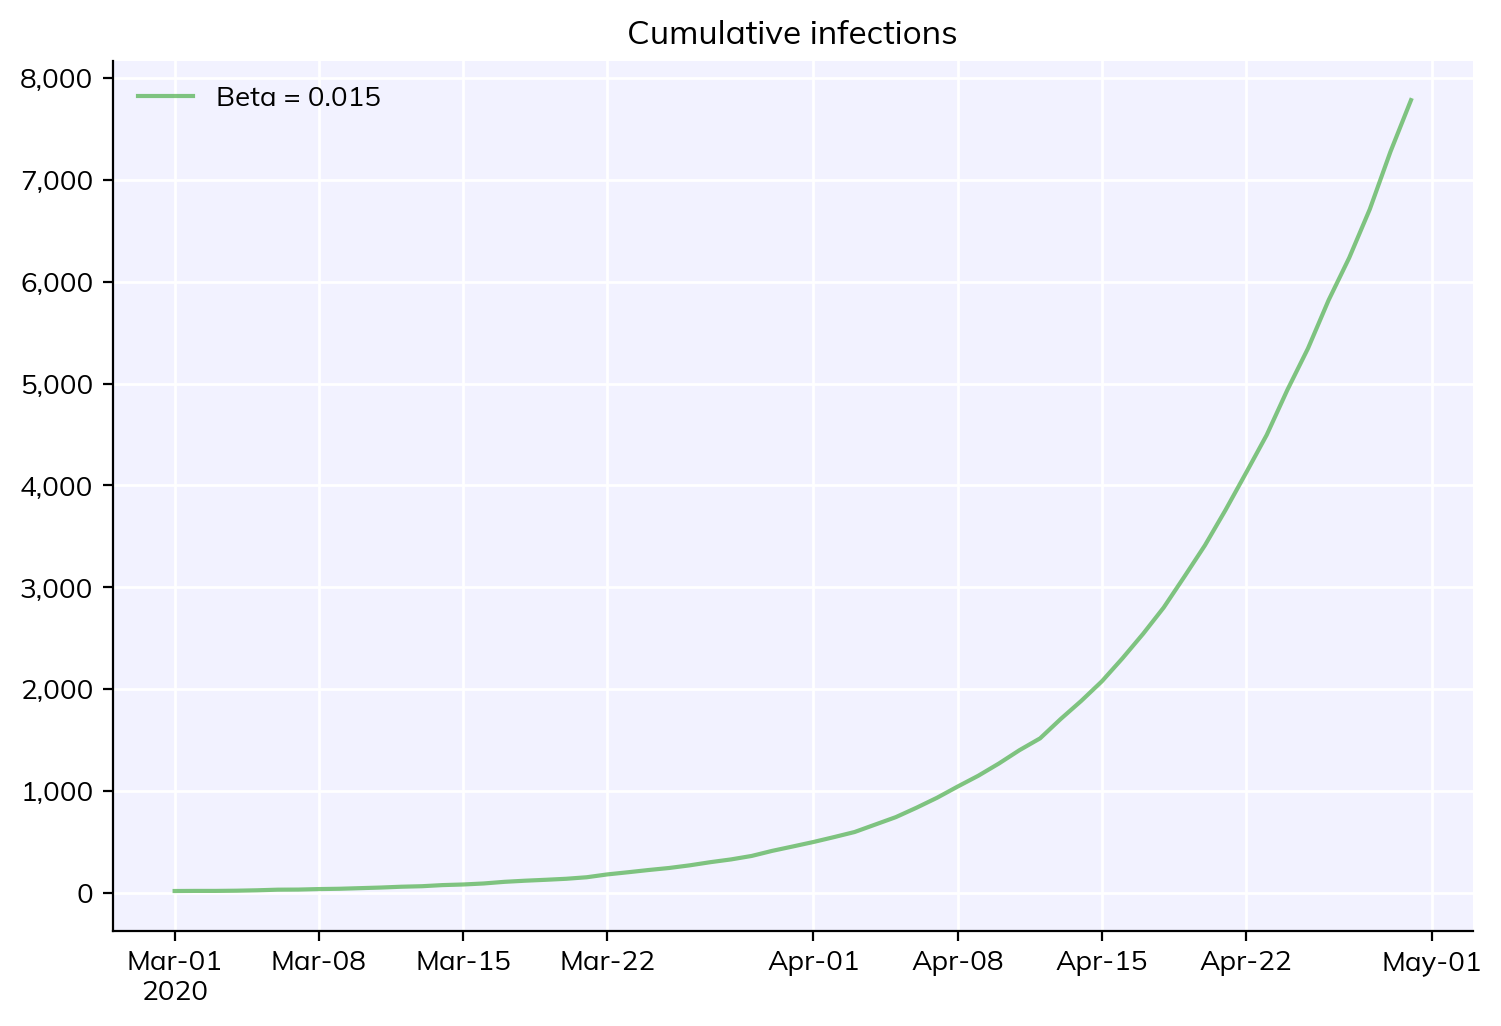

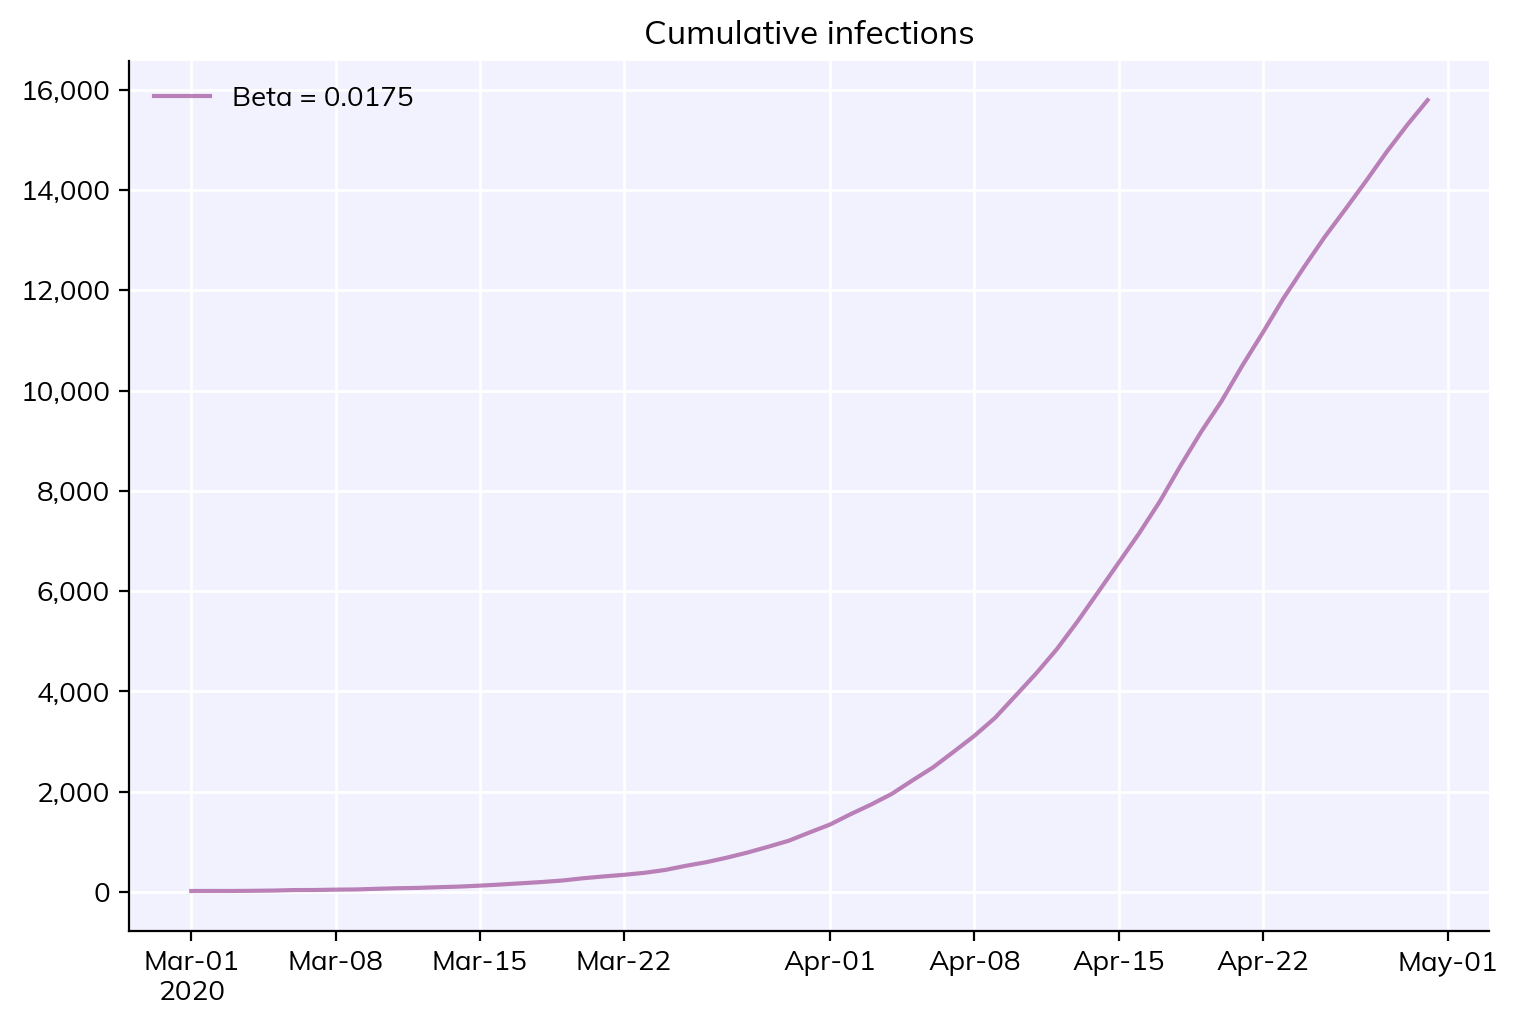

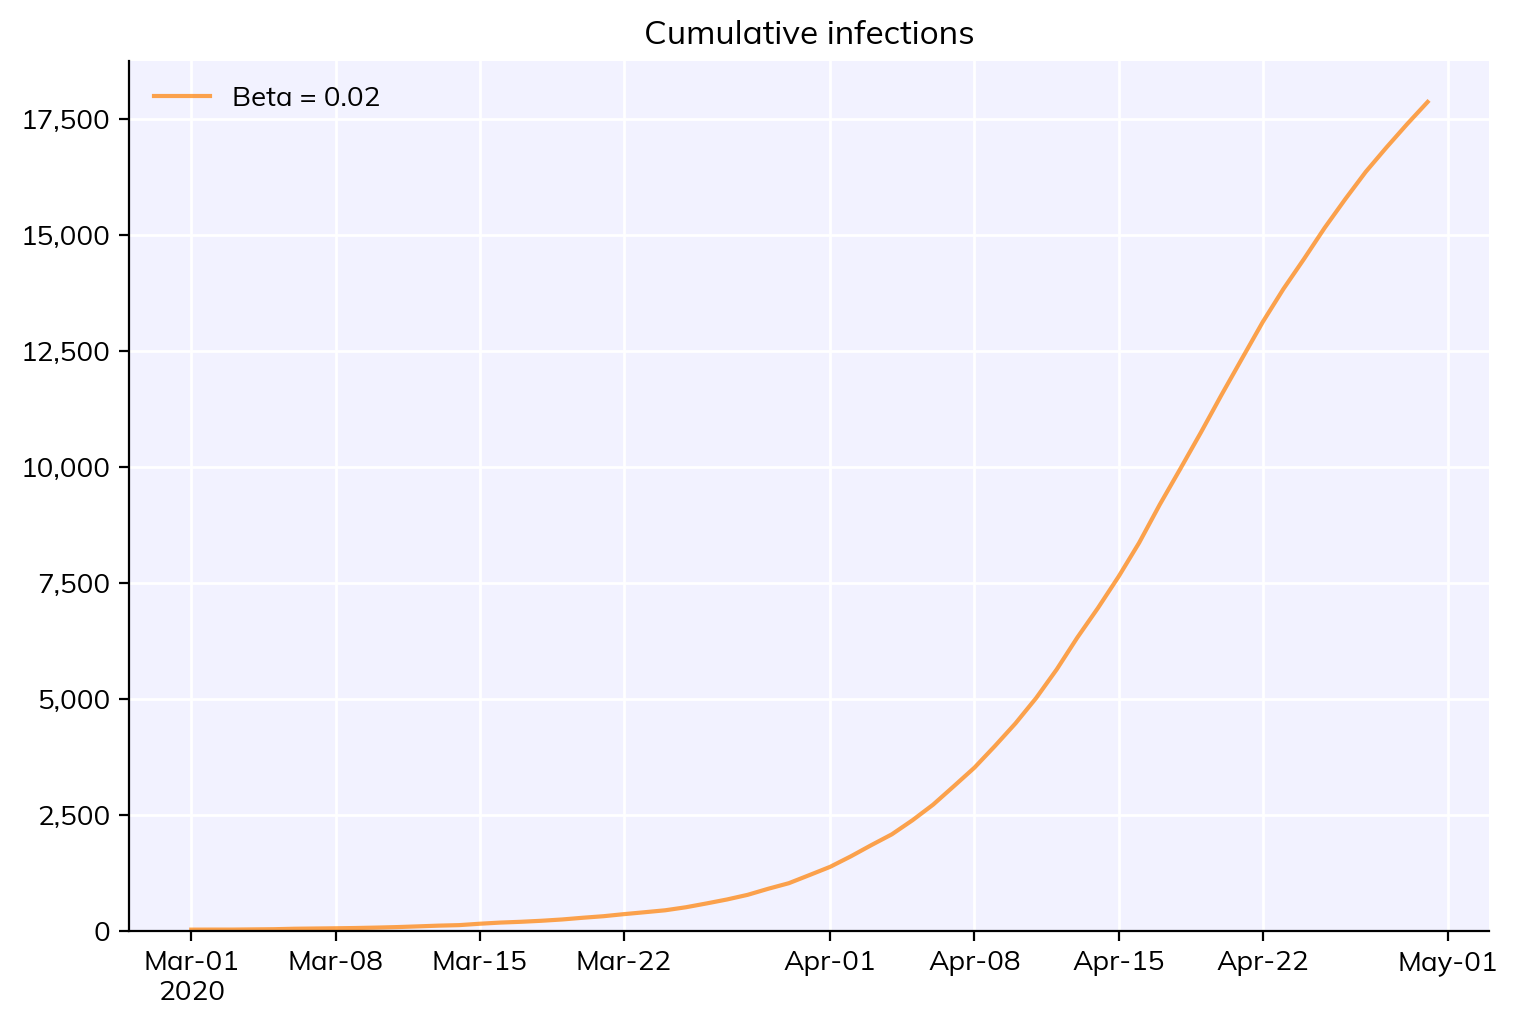

In [6]:
import numpy as np

betas = np.linspace(0.010, 0.020, 5) # Sweep beta from 0.01 to 0.02 with 5 values
sims = []
for beta in betas:
    sim = cv.Sim(beta=beta, label=f'Beta = {beta}')
    sims.append(sim)
msim = cv.MultiSim(sims)
msim.run()
msim.plot_result('cum_infections')

As you would expect, higher beta values have more infections.

Finally, note that you can use multisims to do very compact scenario explorations -- here we are using the command `cv.parallel()`, which is an alias for `cv.MultiSim().run()`:

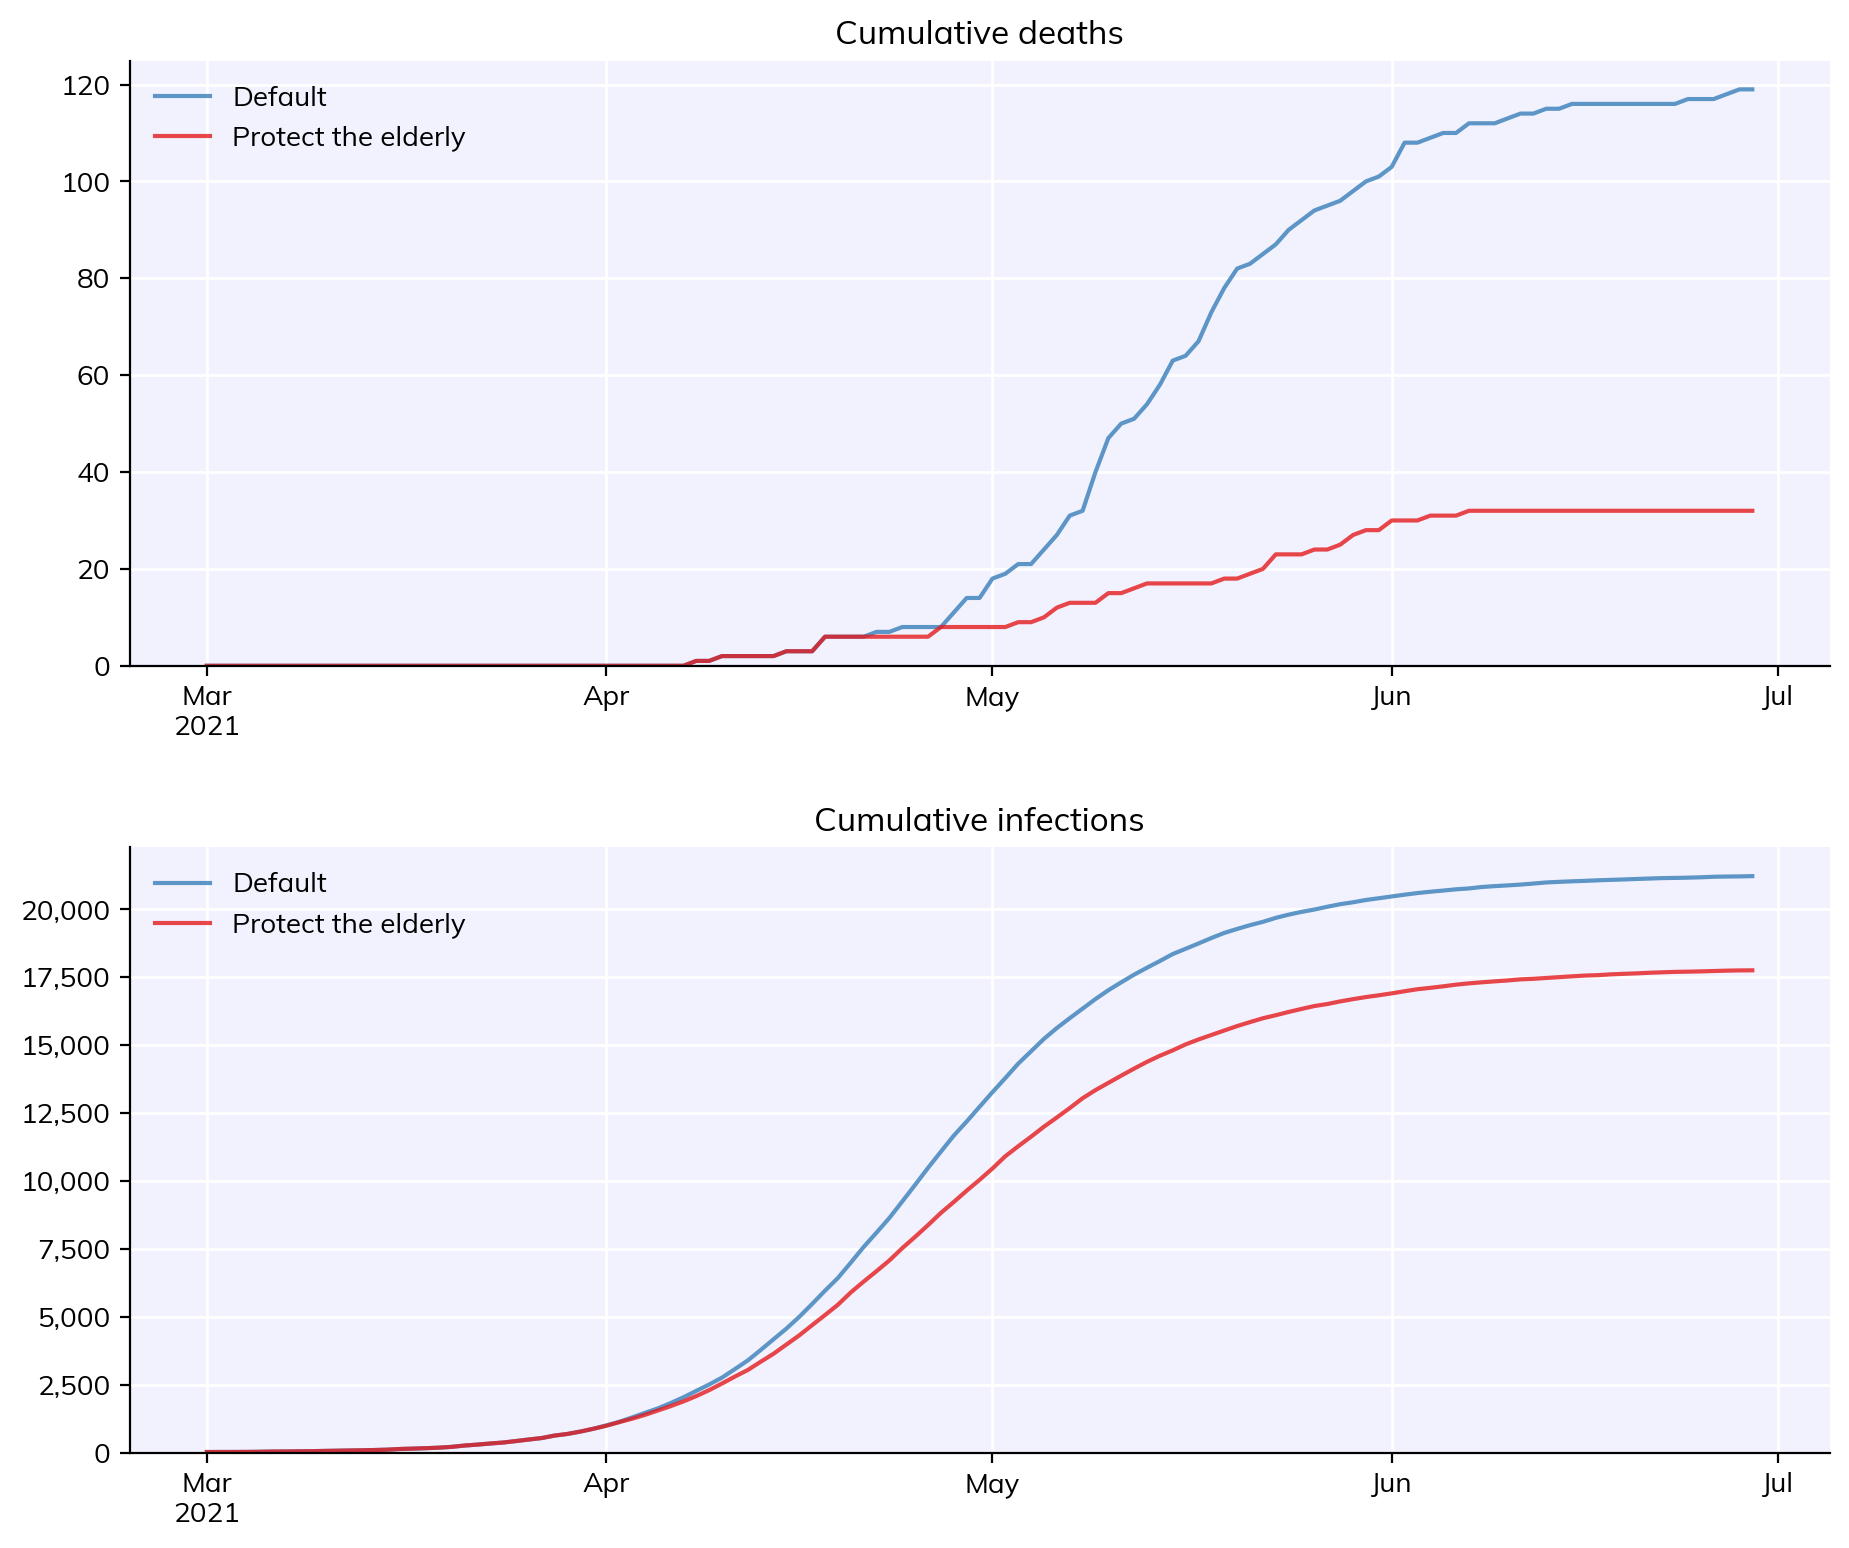

In [7]:
def protect_elderly(sim):
    if sim.t == sim.day('2021-04-01'):
        elderly = sim.people.age>70
        sim.people.rel_sus[elderly] = 0.0

pars = {'start_day':'2021-03-01', 'n_days':120}
s1 = cv.Sim(pars, label='Default')
s2 = cv.Sim(pars, label='Protect the elderly', interventions=protect_elderly)
cv.parallel(s1, s2).plot(['cum_deaths', 'cum_infections']) #cv.parallel(), which is an alias for cv.MultiSim().run()

<div class="alert alert-warning">

**Gotcha:** Because `multiprocess` pickles the sims when running them, `sims[0]` (before being run by the multisim) and `msim.sims[0]` are **not** the same object. After calling `msim.run()`, always use sims from the multisim object, not from before. In contrast, if you *don't* run the multisim (e.g. if you make a multisim from already-run sims), then `sims[0]` and `msim.sims[0]` are indeed exactly the same object.

</div>

### Advanced usage

Finally, you can also merge or split different multisims together. Here's an example that's similar to before, except it shows how to run a multisim of different seeds for the same beta value, but then merge multisims for different beta values together into one multisim to rule them all:

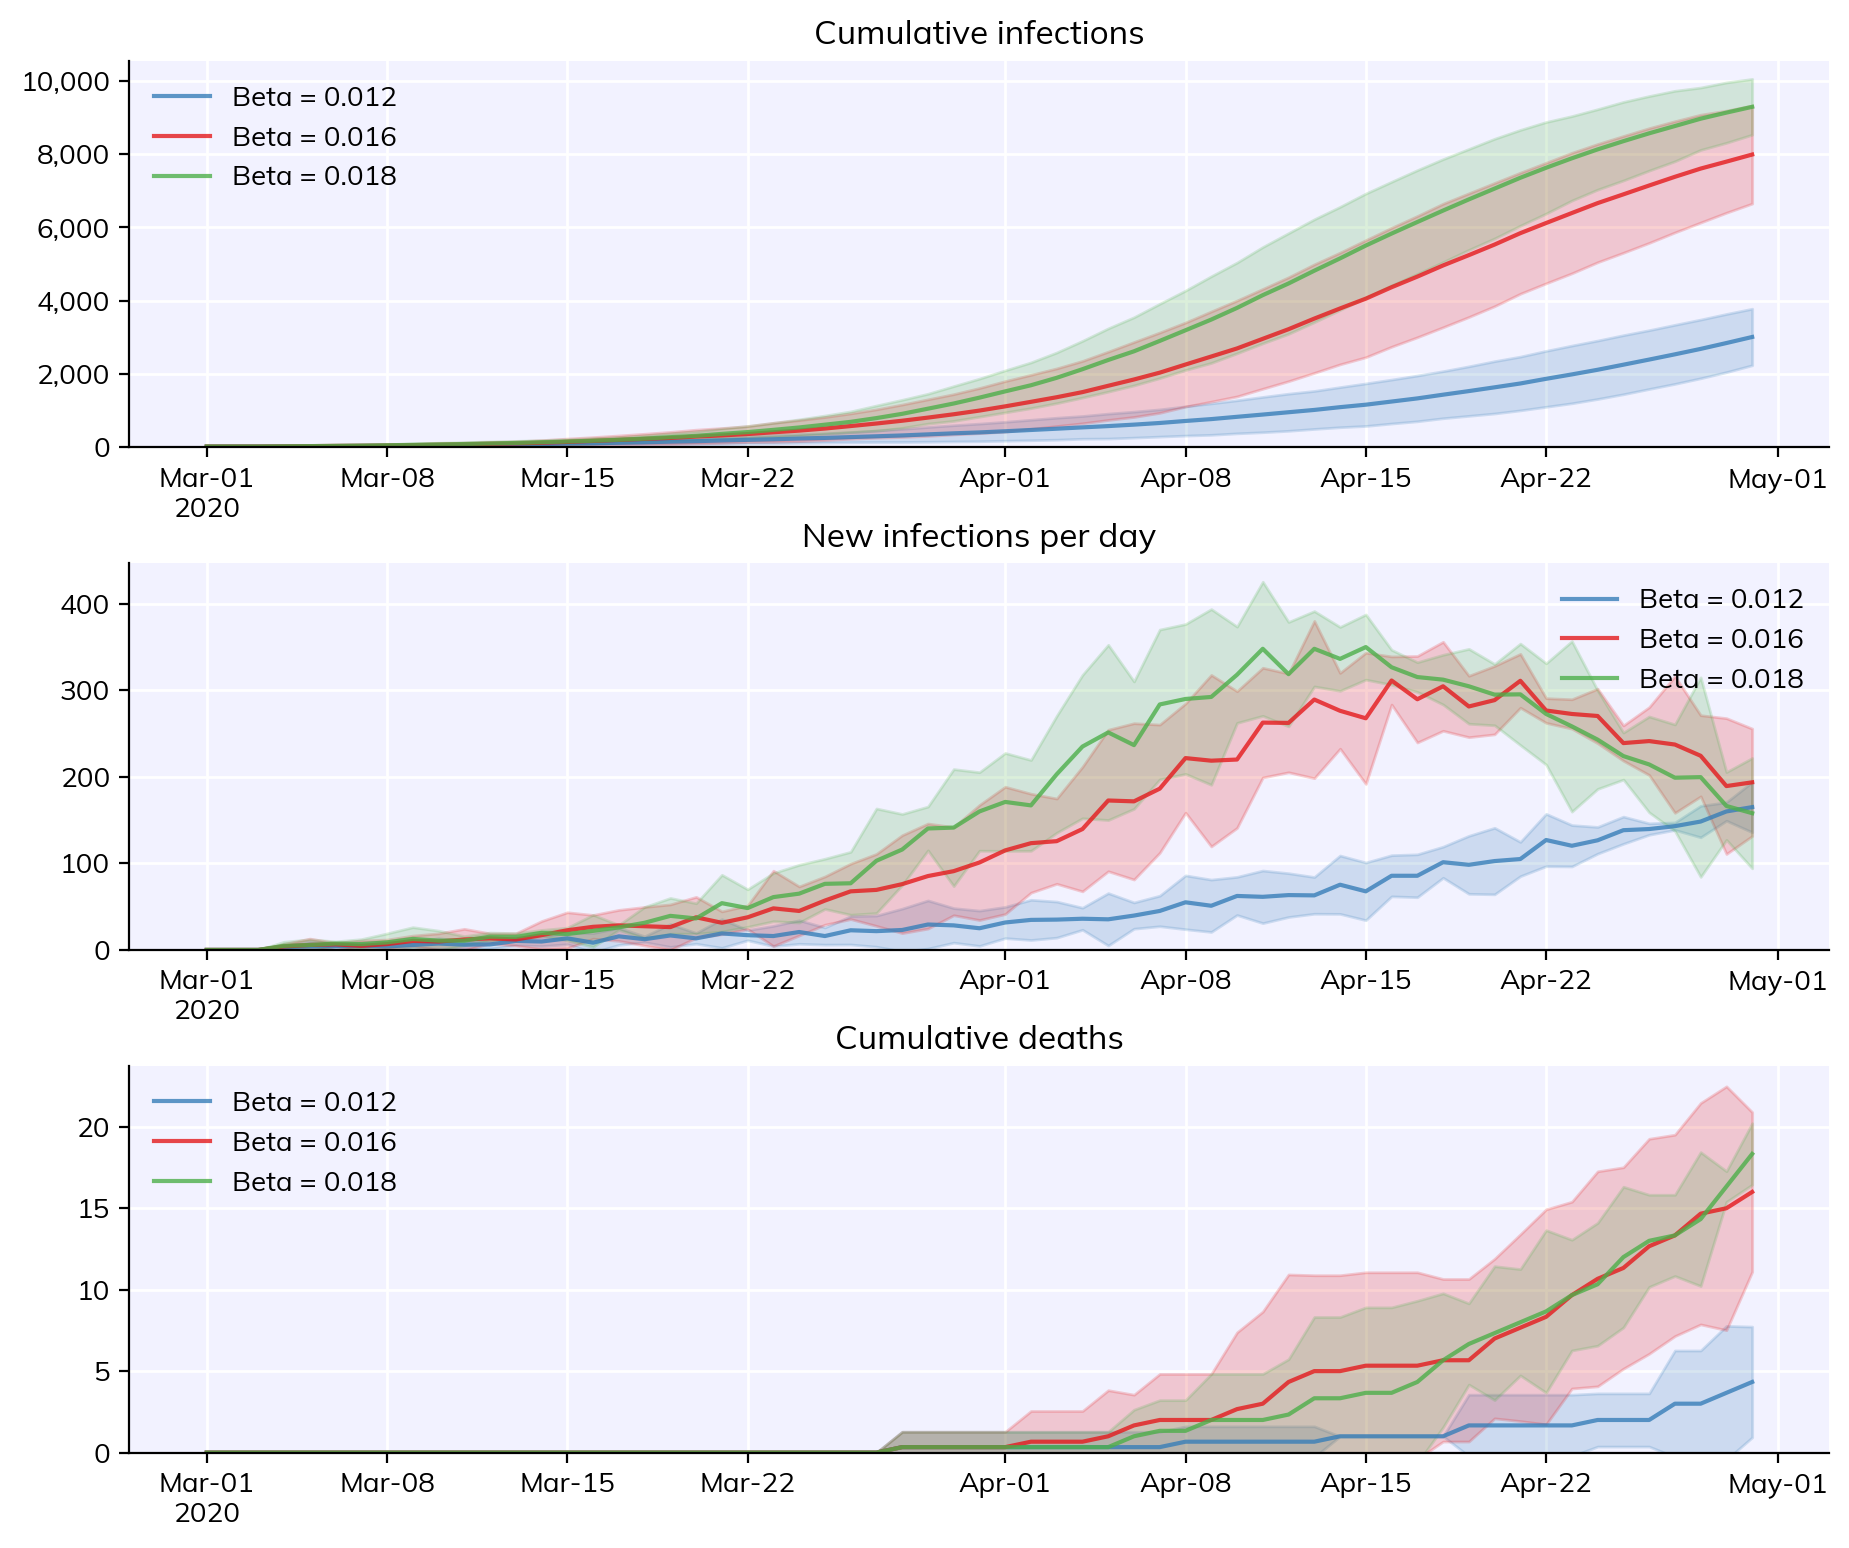

In [8]:
n_sims = 3
betas = [0.012, 0.016, 0.018]

msims = []
for beta in betas:
    sims = []
    for s in range(n_sims):
        sim = cv.Sim(pop_size=10e3, beta=beta, rand_seed=s, label=f'Beta = {beta}')
        sims.append(sim)
    msim = cv.MultiSim(sims)
    msim.run()
    msim.mean()
    msims.append(msim)

merged = cv.MultiSim.merge(msims, base=True)
merged.plot(color_by_sim=True)

As you can see, running this way lets you run not just different values, but run different values with uncertainty. Which brings us to...

## Running with Scenarios

Most of the time, you'll want to run with multisims since they give you the most flexibility. However, in certain cases, Scenario objects let you achieve the same thing more simply. Unlike MultiSims, which are completely agnostic about what sims you include, scenarios always start from the same base sim. They then modify the parameters as you specify, and finally add uncertainty if desired. For example, this shows how you'd use scenarios to run the example similar to the one above.

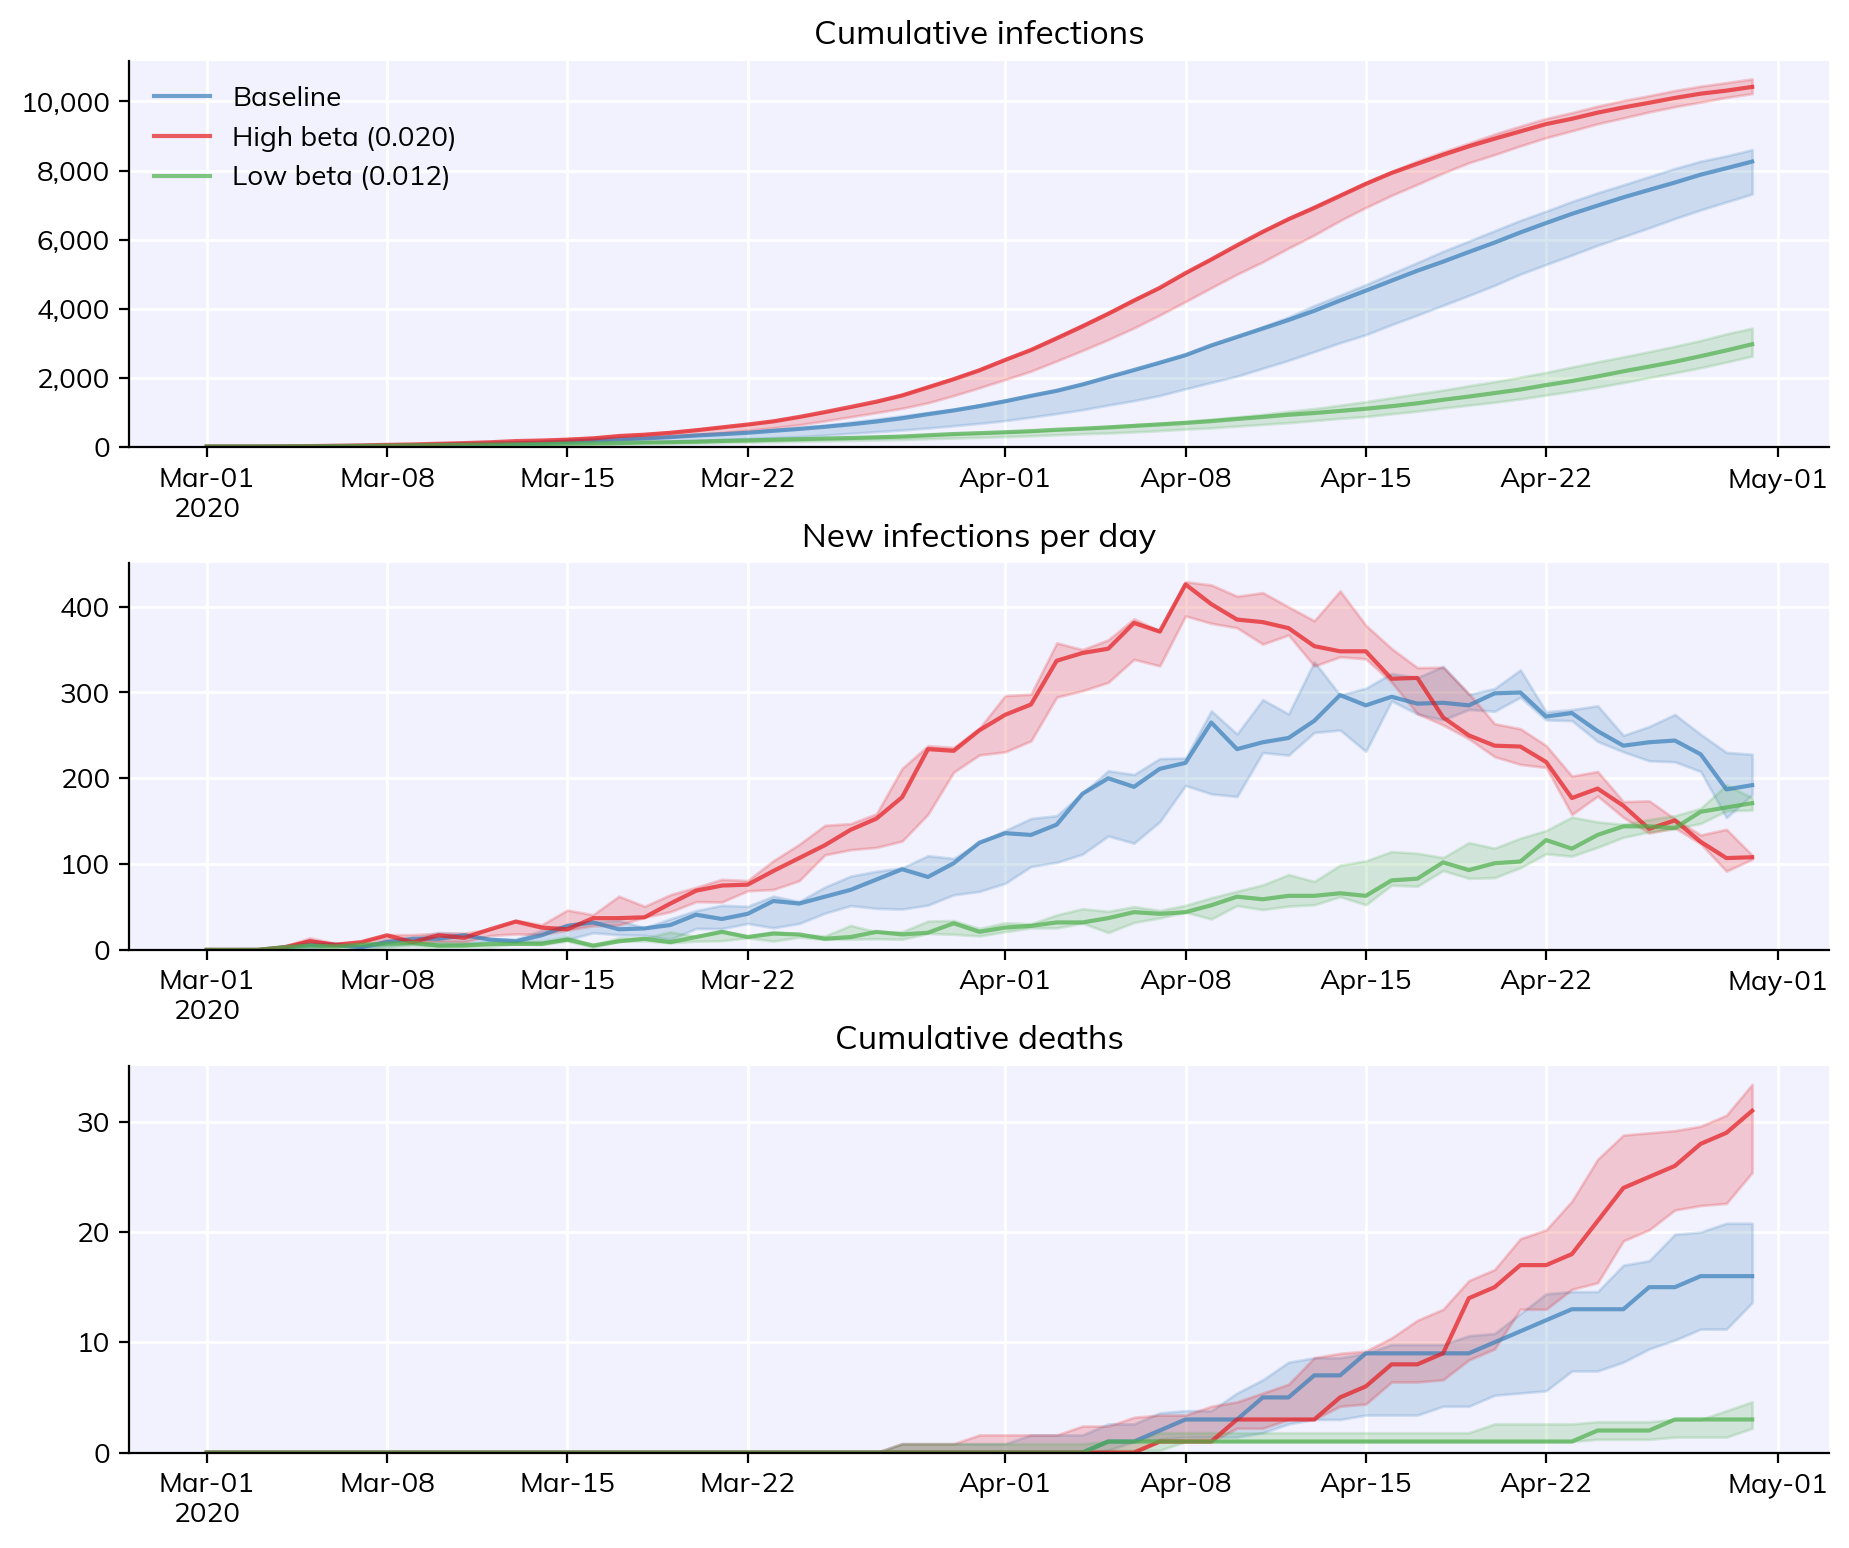

In [9]:
# Set base parameters -- these will be shared across all scenarios
basepars = {'pop_size':10e3} 

# Configure the settings for each scenario
scenarios = {'baseline': {
              'name':'Baseline',
              'pars': {}
              },
            'high_beta': {
              'name':'High beta (0.020)',
              'pars': {
                  'beta': 0.020,
                  }
              },
            'low_beta': {
              'name':'Low beta (0.012)',
              'pars': {
                  'beta': 0.012,
                  }
              },
             }

# Run and plot the scenarios
scens = cv.Scenarios(basepars=basepars, scenarios=scenarios)
scens.run()
scens.plot()